In [13]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from typing import List, Tuple
import warnings
import pickle
from scipy.optimize import bisect

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../.')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images/')
sys.path.append(str(PARENT_DIR))

from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default,hdi,get_data_label


rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR

def get_arrhenius_process_params(ap: LogLinearArrhenius) -> np.ndarray:
    return ap.params[0],ap.params[1]

def get_model_ap_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return (*get_arrhenius_process_params(model.ap1),*get_arrhenius_process_params(model.ap2))

def get_model_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return *get_model_ap_params(model),model.n

class InvertedJMAK:

    def __init__(self,jmak_model: LogLinearArrheniusModelFunc | np.ndarray):
        if isinstance(jmak_model,np.ndarray):
            self.ap1 = LogLinearArrhenius(jmak_model[0:2])
            self.ap2 = LogLinearArrhenius(jmak_model[2:4])
            self.n = jmak_model[4]
            self.jmak_model = None
        
        else:
            self.jmak_model = jmak_model
            self.ap1 = jmak_model.ap1
            self.ap2 = jmak_model.ap2
            self.n = jmak_model.n
    
    def get_time(self, X: np.ndarray,T: np.ndarray) -> np.ndarray:

        tinc = self.ap2(T)
        b = self.ap1(T)
        return 1.0/b*np.log(1./(1. - X))**(1/self.n) + tinc   

    def get_temperature(self, X: np.ndarray,
                              t: np.ndarray,
                              T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
        
        def _search_function(T: float) -> float:
            return self.get_time(X,np.array([T])) - t

        return bisect(_search_function,*T_bounds)

def get_time_from_jmak_samples(X: np.ndarray,
                                T: np.ndarray,
                                a1: np.ndarray,
                                a2: np.ndarray,
                                B1: np.ndarray,
                                B2: np.ndarray,
                                n: np.ndarray) -> np.ndarray:
    
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0/b*np.log(1./(1. - X))**(1/n) + t_inc  

def jmak_prediction_from_samples(t: np.ndarray,
                                 T: np.ndarray,
                                 a1: np.ndarray,
                                 a2: np.ndarray,
                                 B1: np.ndarray,
                                 B2: np.ndarray,
                                 n: np.ndarray) -> np.ndarray:
        
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    t_eff = t - t_inc
    t_eff[t_eff < 0.] = 0.0   

    return 1. - np.exp(-(b**n*t_eff**n))

### Comparison with Nogami Data

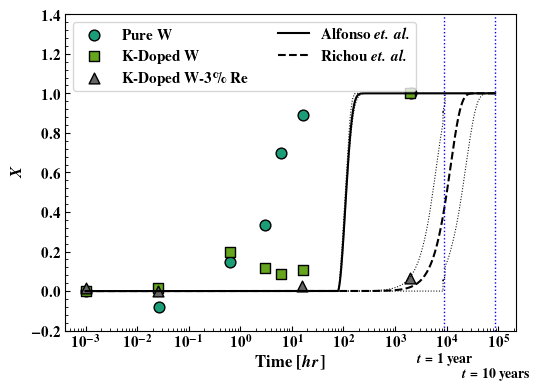

In [2]:
pure_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CPure W Data.csv',index_col = None)
k_doped_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W Data.csv',index_col = None)
for df in [pure_w_df,k_doped_w_df]:
    df['X']  = 1 + (df['hardness'].min()  - df['hardness'])/(df['hardness'].iloc[0] - df['hardness'].min())

k_doped_re3_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W-3Re Data.csv',index_col = None)
k_doped_re3_w_df['X'] = 1 - (k_doped_re3_w_df['hardness'] - 0.208*k_doped_re3_w_df['hardness'].max())/(k_doped_re3_w_df['hardness'].max() - k_doped_re3_w_df['hardness'].max()*0.208)
fig,ax = plt.subplots(figsize = (5.5,4))

setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Time [$hr$]}',fontsize = 12)
ax.set_ylabel(r'$X$',fontsize = 12)

symbols = ['o','s','^']
colors = plt.get_cmap('Dark2')(np.linspace(0.1,0.9,len(symbols)))
labels = [r'Pure W',r'K-Doped W',r'K-Doped W-3\% Re'] 

min_t = float('inf')
max_t = -float('inf')
for df,color,symbol,label in zip([pure_w_df,k_doped_w_df,k_doped_re3_w_df],colors,symbols,labels):
    ax.scatter(df['time [hr]'],df['X'],facecolor = color,edgecolor = 'k',s = 60,
               marker = symbol,label = r'\textbf{' + label + r'}')
    min_t = min(min_t,df['time [hr]'].min())
    max_t = max(max_t,df['time [hr]'].max())


files = ['rf_data/alfonso_data/highly_rolled.csv','rf_data/richou_data/batch_a_data.csv']
model_name = 'JMAK_{}'

styles = ['-','--']
labels = [r'\textbf{Alfonso \textit{et. al.}}',r'\textbf{Richou \textit{et. al.}}']


time = np.linspace(min_t,HOURS_TO_YEAR*10,int(1e5))*SECONDS_TO_HOURS
temperature = np.ones_like(time)*1100.0 + 273.15

for file,style,label in zip(files,styles,labels):
    
    with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
        posterior_samples = pickle.load(f)
    
    
    X_samples = jmak_prediction_from_samples(time[np.newaxis,:],
                                             temperature[np.newaxis,:],
                                             posterior_samples['a1'][:,np.newaxis],
                                              posterior_samples['a2'][:,np.newaxis],
                                              posterior_samples['B1'][:,np.newaxis],
                                              posterior_samples['B2'][:,np.newaxis],
                                              posterior_samples['n'][:,np.newaxis])
    
    intervals_X = hdi(X_samples.T,0.95)
    for i in range(2):
        #filtered = savgol_filter(intervals_X[:,i],100,3)
        ax.plot(time/SECONDS_TO_HOURS,intervals_X[:,i],color = 'k',lw = 0.75,ls = ':')
    
    
    map_est = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)
    map_est= map_est.loc[['a1','a2','B1','B2','n'],'ml'].to_numpy()
    map_est= [np.array([[a]]) for a in map_est]    
    X_map= jmak_prediction_from_samples(time[np.newaxis,:],
                                             temperature[np.newaxis,:],
                                            *map_est)
    

    ax.plot(time/SECONDS_TO_HOURS,X_map.squeeze(),color = 'k',lw = 1.5,ls = style,label = label)

ax.axvline(HOURS_TO_YEAR*1,color = 'blue',lw = 1.0,ls = ':')
ax.axvline(HOURS_TO_YEAR*10,color = 'blue',lw = 1.0,ls = ':')

ax.text(HOURS_TO_YEAR*1, ax.get_ylim()[0] - 0.175, r'\textbf{$t$ = 1 year}', color='k', ha='center', va='top')
ax.text(HOURS_TO_YEAR*10, ax.get_ylim()[0] - 0.25, r'\textbf{$t$ = 10 years}', color='k', ha='center', va='top')


ax.set_xscale('log')
ax.set_ylim([-0.2,1.4])
ax.legend(fontsize = 11,ncols = 2,loc = 'upper left')
fig.tight_layout()
fig.savefig('.temp_images/nogami_rx_comp.svg')





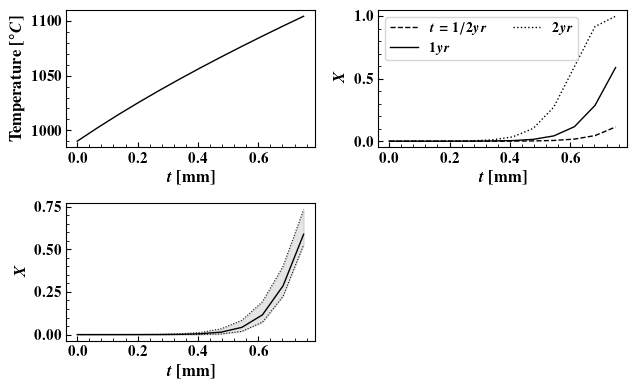

In [14]:
from fluentpy.fluentio import SurfaceFile
data_label = 'Lopez et al. (2015) - MR'
model_name = 'JMAK_{}'

with SurfaceFile('temperature_thru_thick.surf.out') as sfile:
    df = sfile.readdf()

with warnings.catch_warnings(action = 'ignore'):
    df.sort_values('y-coordinate',inplace = True)
    df['y-coordinate'] -= df['y-coordinate'].min()

time = 1*SECONDS_TO_YEAR
temperature = df['temperature'].to_numpy()
with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_label)}_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

ml_est =  pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_label)}_params.csv'),index_col = 0)
ml_est= ml_est.loc[['a1','a2','B1','B2','n'],'ml'].to_numpy()
ml_est= [np.array([[a]]) for a in ml_est]    
X_ml= jmak_prediction_from_samples(time,
                                            temperature[np.newaxis,:],
                                        *ml_est)

X_samples = jmak_prediction_from_samples(time,
                                    temperature[np.newaxis,:],
                                    posterior_samples['a1'][:,np.newaxis],
                                    posterior_samples['a2'][:,np.newaxis],
                                    posterior_samples['B1'][:,np.newaxis],
                                    posterior_samples['B2'][:,np.newaxis],
                                    posterior_samples['n'][:,np.newaxis])

intervals_X = hdi(X_samples.T,0.95)

fig,axes = plt.subplots(nrows = 2,ncols = 2,figsize = (6.5,4.))
for ax in axes.ravel():
    setup_axis_default(ax)

    ax.set_xlabel(r'$t$ \textbf{[mm]}',fontsize = 12)

axes[0,0].set_ylabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
axes[0,0].plot(df['y-coordinate']*1e3,df['temperature'] - 273.15,color = 'k',lw = 1.0)
axes[1,0].set_ylabel(r'$X$',fontsize = 12) 
axes[1,0].plot( df['y-coordinate']*1e3,X_ml.squeeze(),color = 'k',lw = 1.0)
axes[1,0].fill_between(df['y-coordinate']*1e3,intervals_X[:,0],intervals_X[:,1],color = 'k',alpha = 0.1)
for i in range(2):
    axes[1,0].plot(df['y-coordinate']*1e3,intervals_X[:,i],lw = 0.75,color ='k',ls = ':')


labels = [r'$t = 1/2 yr$',r'$1 yr$',r'$2 yr$']
for time,ls,label in zip([0.5,1,2],['--','-',':'],labels):
    time = time*SECONDS_TO_YEAR  
    X_ml= jmak_prediction_from_samples(time,
                                                temperature[np.newaxis,:],
                                            *ml_est)
    axes[0,1].plot( df['y-coordinate']*1e3,X_ml.squeeze(),color = 'k',lw = 1.0,ls = ls,label = label)

axes[0,1].set_ylabel(r'$X$',fontsize = 12) 
axes[1,1].axis('off')
axes[0,1].legend(fontsize = 10,ncols = 2)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('temperature_rx_phase_through_thickness.svg'))
